# Modeling Data

In [1]:
import io, os, sys, types

In [2]:
import nbformat

from IPython import get_ipython
from IPython.core.interactiveshell import InteractiveShell

In [3]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path
    
    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

In [4]:
class NotebookLoader(object):
    """Module Loader for IPython Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path
    
    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)
        
        print ("importing notebook from %s" % path)
                                       
        # load the notebook object
        nb = nbformat.read(path, as_version=4)
        
        
        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod
        
        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__
        
        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

importing notebook from EDA.ipynb
['Station' 'Date' 'Tmax' 'Tmin' 'Tavg' 'Depart' 'DewPoint' 'WetBulb' 'Heat'
 'Cool' 'Sunrise' 'Sunset' 'CodeSum' 'Depth' 'Water1' 'SnowFall'
 'PrecipTotal' 'StnPressure' 'SeaLevel' 'ResultSpeed' 'ResultDir'
 'AvgSpeed']
Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
CodeSum        0
Depth          0
Water1         0
SnowFall       0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64
Station          int64
Date            object
Tmax             int64
Tmin             int64
Tavg            object
Depart          object
DewPoint         int64
WetBulb         object
Heat            object
Cool            object
Sunrise         object
Sunset          object
CodeSum         object
Depth           object
Water1          object
SnowFall      

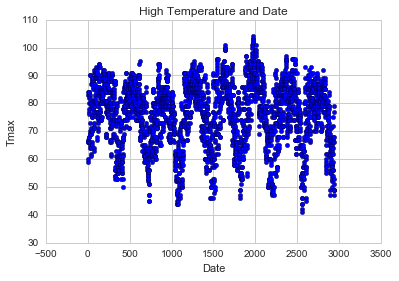

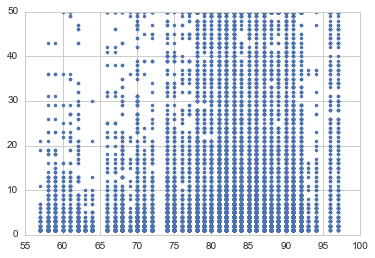

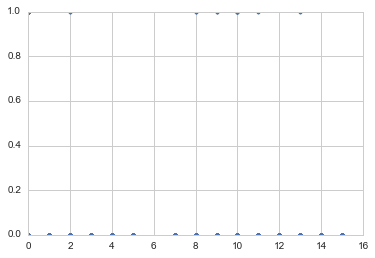

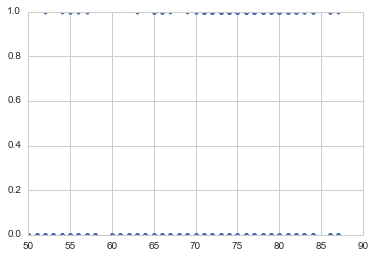

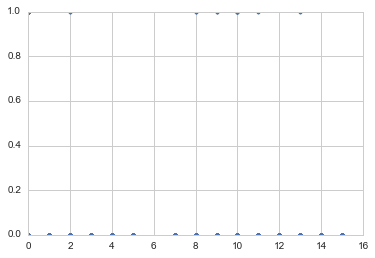

In [10]:
import EDA

In [11]:
class NotebookFinder(object):
    """Module finder that locates IPython Notebooks"""
    def __init__(self):
        self.loaders = {}
    
    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return
        
        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)
        
        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

In [12]:
sys.meta_path.append(NotebookFinder())

In [17]:
print EDA.data

            Date  Tmax
0     2007-05-01    83
1     2007-05-01    84
2     2007-05-02    59
3     2007-05-02    60
4     2007-05-03    66
5     2007-05-03    67
6     2007-05-04    66
7     2007-05-04    78
8     2007-05-05    66
9     2007-05-05    66
10    2007-05-06    68
11    2007-05-06    68
12    2007-05-07    83
13    2007-05-07    84
14    2007-05-08    82
15    2007-05-08    80
16    2007-05-09    77
17    2007-05-09    76
18    2007-05-10    84
19    2007-05-10    83
20    2007-05-11    70
21    2007-05-11    73
22    2007-05-12    64
23    2007-05-12    65
24    2007-05-13    69
25    2007-05-13    69
26    2007-05-14    90
27    2007-05-14    90
28    2007-05-15    80
29    2007-05-15    82
...          ...   ...
2914  2014-10-17    62
2915  2014-10-17    63
2916  2014-10-18    50
2917  2014-10-18    52
2918  2014-10-19    54
2919  2014-10-19    57
2920  2014-10-20    65
2921  2014-10-20    66
2922  2014-10-21    53
2923  2014-10-21    54
2924  2014-10-22    56
2925  2014-